# o'reillyのカサゴ深層学習の本

## ニューラルネットワークの構成要素

## [目次](TableOfContents.ipynb)
- [環境準備](#環境準備)
  - [インポート](#インポート)
  - [共通関数](#共通関数)
- 深層のCNN
  - [深層のCNNの実装](#深層のCNNの実装)
  - [深層のCNNを訓練してセーブ](#深層のCNNを訓練してセーブ)
  - [深層のCNNをロードして推論](#深層のCNNをロードして推論)
  
## 参考
- https://github.com/oreilly-japan/deep-learning-from-scratch/blob/master/notebooks/
- [深層学習（deep learning） - 開発基盤部会 Wiki](https://dotnetdevelopmentinfrastructure.osscons.jp/index.php?%E6%B7%B1%E5%B1%A4%E5%AD%A6%E7%BF%92%EF%BC%88deep%20learning%EF%BC%89) > [ニューラルネットワーク
](https://dotnetdevelopmentinfrastructure.osscons.jp/index.php?plugin=related&page=%E3%83%8B%E3%83%A5%E3%83%BC%E3%83%A9%E3%83%AB%E3%83%8D%E3%83%83%E3%83%88%E3%83%AF%E3%83%BC%E3%82%AF) > [畳み込みニューラルネットワーク（CNN）
](https://dotnetdevelopmentinfrastructure.osscons.jp/index.php?%E7%95%B3%E3%81%BF%E8%BE%BC%E3%81%BF%E3%83%8B%E3%83%A5%E3%83%BC%E3%83%A9%E3%83%AB%E3%83%8D%E3%83%83%E3%83%88%E3%83%AF%E3%83%BC%E3%82%AF%EF%BC%88CNN%EF%BC%89)

## 環境準備

### インポート

In [1]:
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import pickle
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from kasago.common.layers import *
from kasago.dataset.mnist import load_mnist
from kasago.common.trainer import Trainer

### 共通関数

In [2]:
# ...

## 深層のCNN

### 深層のCNNの実装

In [3]:
class DeepConvNet:
    """認識率99%以上の高精度なConvNet

    ネットワーク構成は下記の通り
        conv - relu - conv- relu - pool -
        conv - relu - conv- relu - pool -
        conv - relu - conv- relu - pool -
        affine - relu - dropout -
        affine - dropout - softmax
    """
    def __init__(self, input_dim=(1, 28, 28),
                 conv_param_1 = {'filter_num':16, 'filter_size':3, 'pad':1, 'stride':1},
                 conv_param_2 = {'filter_num':16, 'filter_size':3, 'pad':1, 'stride':1},
                 conv_param_3 = {'filter_num':32, 'filter_size':3, 'pad':1, 'stride':1},
                 conv_param_4 = {'filter_num':32, 'filter_size':3, 'pad':2, 'stride':1},
                 conv_param_5 = {'filter_num':64, 'filter_size':3, 'pad':1, 'stride':1},
                 conv_param_6 = {'filter_num':64, 'filter_size':3, 'pad':1, 'stride':1},
                 hidden_size=50,
                 output_size=10):
        
        # 重みの初期化===========
        self.params = {}

        # チャンネル数
        pre_channel_num = input_dim[0]
        
        # ReLUを使う場合に推奨されるHeの初期値（平均0、標準偏差√(2/前層ノード数)である正規分布
        # 各層のニューロン数は自動計算だが重みは手動計算
        # この前層ノード数はconvの重みの行数に一致するので（FH * FW * CH）で計算できる。
        # ただし、最後のW7だけは Affine層なので要素の個数は1つ前の要素数で
        # フィルタ数 * 特徴マップのサイズだが HWS = 2 の Poolingを3回通るので
        #  特徴マップのサイズは、28*)28/2 → 14/2 → 7/2 → 4(*4 になる。
        pre_node_nums = np.array([1*3*3, 16*3*3, 16*3*3, 32*3*3, 32*3*3, 64*3*3, 64*4*4, hidden_size])
        weight_init_scales = np.sqrt(2.0 / pre_node_nums)
        
        # conv
        for idx, conv_param in enumerate(
            [conv_param_1, conv_param_2, conv_param_3, conv_param_4, conv_param_5, conv_param_6]):
            # convの重みの行列サイズは（FH * FW * CH数）行 * （フィルタ数）列
            self.params['W' + str(idx+1)] = weight_init_scales[idx] * np.random.randn(conv_param['filter_num'], pre_channel_num, conv_param['filter_size'], conv_param['filter_size'])
            # convのバイアス？
            self.params['b' + str(idx+1)] = np.zeros(conv_param['filter_num'])
            # 初回は前チャネル数だが以降は前フィルタ数になる。
            pre_channel_num = conv_param['filter_num']
            
        # affine
        # W7はAffine層なので要素の個数は1つ前の要素数（64*4*4行50列）
        self.params['W7'] = weight_init_scales[6] * np.random.randn(64*4*4, hidden_size)
        self.params['b7'] = np.zeros(hidden_size)
        # 同様に、W8もAffine層なので要素の個数は1つ前の要素数（50行10列）
        self.params['W8'] = weight_init_scales[7] * np.random.randn(hidden_size, output_size)
        self.params['b8'] = np.zeros(output_size)

        # レイヤの生成===========
        self.layers = []
        # (100,1,28,28)
        
        #conv1 FN:16, FH:3, FW:3, P:1, S:1
        self.layers.append(Convolution(self.params['W1'], self.params['b1'], 
                           conv_param_1['stride'], conv_param_1['pad']))
        # (100,16,28,28)
        self.layers.append(Relu())
        # (100,16,28,28)
        
        #conv2 FN:16, FH:3, FW:3, P:1, S:1
        self.layers.append(Convolution(self.params['W2'], self.params['b2'], 
                           conv_param_2['stride'], conv_param_2['pad']))
        # (100,16,28,28)
        self.layers.append(Relu())
        # (100,16,28,28)
        self.layers.append(Pooling(pool_h=2, pool_w=2, stride=2))
        # (100,16,14,14)
        
        #conv3 FN:32, FH:3, FW:3, P:1, S:1
        self.layers.append(Convolution(self.params['W3'], self.params['b3'], 
                           conv_param_3['stride'], conv_param_3['pad']))
        # (100,32,14,14)
        self.layers.append(Relu())
        # (100,32,14,14)
        
        #conv4 FN:32, FH:3, FW:3, P:2, S:1
        self.layers.append(Convolution(self.params['W4'], self.params['b4'],
                           conv_param_4['stride'], conv_param_4['pad']))
        # (100,32,16,16) pad=2なのでサイズは+2
        self.layers.append(Relu())
        # (100,32,16,16)
        self.layers.append(Pooling(pool_h=2, pool_w=2, stride=2))
        # (100,32,8,8)
        
        #conv5 FN:64, FH:3, FW:3, P:1, S:1
        self.layers.append(Convolution(self.params['W5'], self.params['b5'],
                           conv_param_5['stride'], conv_param_5['pad']))
        # (100,64,8,8)
        self.layers.append(Relu())
        # (100,64,8,8)
        
        #conv6 FN:64, FH:3, FW:3, P:1, S:1
        self.layers.append(Convolution(self.params['W6'], self.params['b6'],
                           conv_param_6['stride'], conv_param_6['pad']))
        # (100,64,8,8)
        self.layers.append(Relu())
        # (100,64,8,8)
        self.layers.append(Pooling(pool_h=2, pool_w=2, stride=2))
        # (100,64,4,4)
        
        # affine W:(64,4,4, 100)
        self.layers.append(Affine(self.params['W7'], self.params['b7']))
        # (100,50)
        self.layers.append(Relu())
        # (100,50)
        self.layers.append(Dropout(0.5))
        # (100,50)
        
        # Output(affine W:(50, 10)
        self.layers.append(Affine(self.params['W8'], self.params['b8']))
        # (100,10)
        self.layers.append(Dropout(0.5))
        # (100,10)
        self.last_layer = SoftmaxWithLoss()
        # (100,10)
        
    def predict(self, x, train_flg=False):
        for layer in self.layers:
            if isinstance(layer, Dropout):
                x = layer.forward(x, train_flg)
            else:
                x = layer.forward(x)
        return x

    def loss(self, x, t):
        y = self.predict(x, train_flg=True)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)

        acc = 0.0

        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx, train_flg=False)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt)

        return acc / x.shape[0]

    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        tmp_layers = self.layers.copy()
        tmp_layers.reverse()
        for layer in tmp_layers:
            dout = layer.backward(dout)

        # 設定
        grads = {}
        for i, layer_idx in enumerate((0, 2, 5, 7, 10, 12, 15, 18)):
            grads['W' + str(i+1)] = self.layers[layer_idx].dW
            grads['b' + str(i+1)] = self.layers[layer_idx].db

        return grads

    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, layer_idx in enumerate((0, 2, 5, 7, 10, 12, 15, 18)):
            self.layers[layer_idx].W = self.params['W' + str(i+1)]
            self.layers[layer_idx].b = self.params['b' + str(i+1)]

### 深層のCNNを訓練してセーブ
処理が重いので既定でコメントアウト

In [ ]:
'''
# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

# 処理に時間のかかる場合はデータを削減 
#x_train, t_train = x_train[:5000], t_train[:5000]
#x_test, t_test = x_test[:1000], t_test[:1000]
x_train, t_train = x_train[:500], t_train[:500]
x_test, t_test = x_test[:100], t_test[:100]

max_epochs = 20
network = DeepConvNet()  
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr':0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

# パラメータの保存
network.save_params("../work/deep_convnet_params.pkl")
print("Saved Network Parameters!")

# グラフの描画
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()
'''

### 深層のCNNをロードして推論

calculating test accuracy ... 
test accuracy:0.9797
======= misclassified result =======
{view index: (label, inference), ...}
{1: (np.uint8(9), np.int64(8)), 2: (np.uint8(9), np.int64(8)), 3: (np.uint8(9), np.int64(8)), 4: (np.uint8(6), np.int64(0)), 5: (np.uint8(8), np.int64(5)), 6: (np.uint8(9), np.int64(8)), 7: (np.uint8(2), np.int64(7)), 8: (np.uint8(6), np.int64(0)), 9: (np.uint8(4), np.int64(1)), 10: (np.uint8(4), np.int64(9)), 11: (np.uint8(3), np.int64(2)), 12: (np.uint8(8), np.int64(2)), 13: (np.uint8(8), np.int64(2)), 14: (np.uint8(1), np.int64(8)), 15: (np.uint8(3), np.int64(9)), 16: (np.uint8(7), np.int64(2)), 17: (np.uint8(1), np.int64(7)), 18: (np.uint8(5), np.int64(8)), 19: (np.uint8(4), np.int64(9)), 20: (np.uint8(4), np.int64(9))}


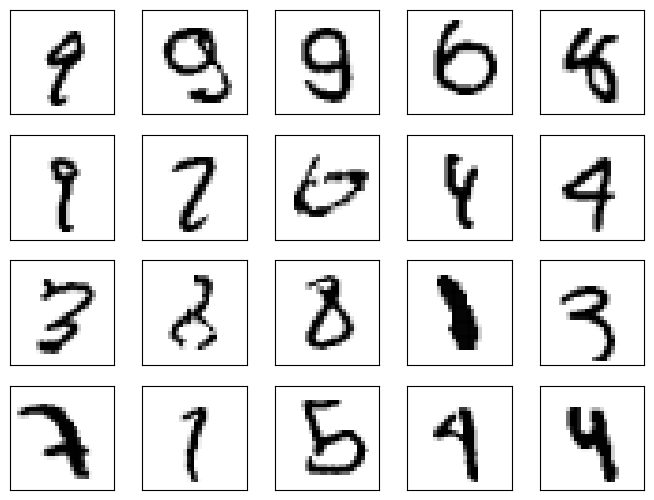

In [5]:
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

network = DeepConvNet()
network.load_params("../work/deep_convnet_params.pkl")

print("calculating test accuracy ... ")
#sampled = 1000
#x_test = x_test[:sampled]
#t_test = t_test[:sampled]

classified_ids = []

acc = 0.0
batch_size = 100

for i in range(int(x_test.shape[0] / batch_size)):
    tx = x_test[i*batch_size:(i+1)*batch_size]
    tt = t_test[i*batch_size:(i+1)*batch_size]
    y = network.predict(tx, train_flg=False)
    y = np.argmax(y, axis=1)
    classified_ids.append(y)
    acc += np.sum(y == tt)
    
acc = acc / x_test.shape[0]
print("test accuracy:" + str(acc))

classified_ids = np.array(classified_ids)
classified_ids = classified_ids.flatten()
 
max_view = 20
current_view = 1

fig = plt.figure()
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.2, wspace=0.2)

mis_pairs = {}
for i, val in enumerate(classified_ids == t_test):
    if not val:
        ax = fig.add_subplot(4, 5, current_view, xticks=[], yticks=[])
        ax.imshow(x_test[i].reshape(28, 28), cmap=plt.cm.gray_r, interpolation='nearest')
        mis_pairs[current_view] = (t_test[i], classified_ids[i])
            
        current_view += 1
        if current_view > max_view:
            break

print("======= misclassified result =======")
print("{view index: (label, inference), ...}")
print(mis_pairs)

plt.show()